# <center> Mapper Algorithm and Inverse Bonds Analysis </center>

### Intro
#### What is TDA?
Topological data analysis (TDA) is a new data analytics paradigm that analyzes the topological shape of data. TDA is built on modern mathematical theory that combines algebraic topology and cohomology to rigorously study the data shape. The modern mathematics makes TDA a potent data analytics tool because TDA is robust to selection of metric, the curse of dimensionality, and noise. In addition, TDA bridges the gap between current pure math research fields and applied/computational research, allowing researchers the ability to apply modern pure math theories.

#### Mapper Algorithm
Mapper is an algorithm developed by [Singh et al](https://research.math.osu.edu/tgda/mapperPBG.pdf) in 2007 as his PhD thesis. Mapper is a computational method that visualizes high dimensional data sets as simplicial complexes, capturing both topological and geometric information. Intuitively one can imagine that the high dimensional data set reduces to a graph (simplicial complex) where nodes correspond to data clusters. Mapper relies on the idea of partial clustering as a key step that applies standard clustering algorithms to subsets of the original data set and then observe how partial clusters are formed and interact with each other. More formally, if $U$ and $V$ are subsets of the data set and $U\cap V$ is non-empty, then the clusters obtained from $U$ and $V$ respectively may have non-empty intersections, and these intersections are the partial clusters used in building a simplicial complex.

Mapper was deemed so valuable to the Defense Advanced Research Projects Agency (DARPA) that they urged Singh and his advisor Carlsson to commercialize Mapper so that they could use it for more applications. Thus [Ayasdi](https://techcrunch.com/2013/01/16/darpa-backed-ayasdi-launches-with-10m-from-khosla-floodgate-to-uncover-the-hidden-value-in-big-data/) was formed a year later in 2008 as the first TDA machine learning business. Since then Mapper [has been used](https://www.diva-portal.org/smash/get/diva2:900997/FULLTEXT01.pdf) to identify unique, novel type 2 diabetes subgroups, breast cancer subgroups with unusually high survival, identify genes that contribute to cancer, and much more.

### Loading Pandas DataFrame

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# maximize row width to see tx ids
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [3]:
# NOTE ./ is for linux machines
# load mev/non-mev daily vol data
ohm_mev_df = pd.read_csv('./data/daily_mev_swaps.csv')  

# load ohm liquidations data
ohm_liq_df = pd.read_csv('./data/ohm_liquidations.csv')


In [4]:
# convert datetime string to datetime object
ohm_mev_df['pair_swaps_datetime'] = pd.to_datetime(ohm_mev_df['pair_swaps_datetime'])

# convert liquidates_datetime column from string to datetime
ohm_liq_df['liquidates_datetime'] = pd.to_datetime(ohm_liq_df['liquidates_datetime'])

In [5]:
# set datetime to index on main ohm mev df
ohm_mev_df = ohm_mev_df.set_index('pair_swaps_datetime')

In [6]:
# combine ohm liq df with ohm_mev_df
ohm_mev_df = ohm_mev_df.join(ohm_liq_df.set_index('liquidates_datetime'), on='pair_swaps_datetime') 

# convert NaN liquidation values to 0
ohm_mev_df = ohm_mev_df.fillna(0)

### Preliminary Analysis of Raw Data

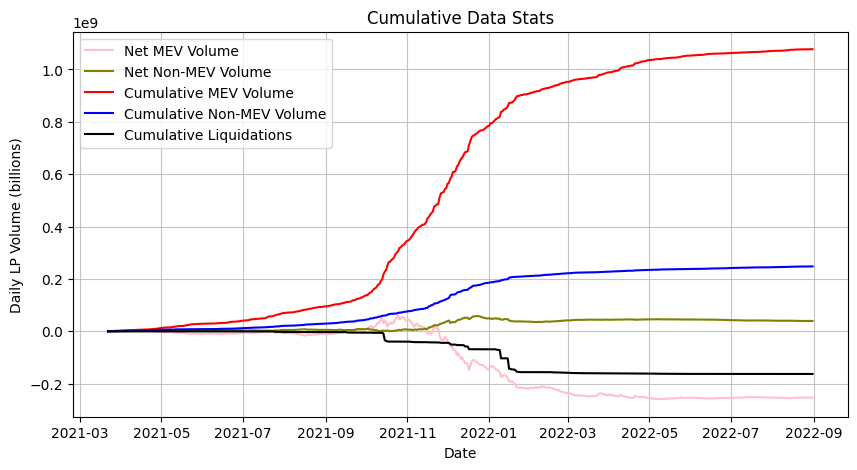

In [7]:
# cumulative line plot of mev vol and non mev vol
plt.figure(figsize=(10,5))
plt.plot(ohm_mev_df.index ,ohm_mev_df.mev_vol.cumsum(), label="Net MEV Volume", c='pink')
plt.plot(ohm_mev_df.index ,ohm_mev_df.non_mev_vol.cumsum(), label="Net Non-MEV Volume", c='olive')
plt.plot(ohm_mev_df.index, ohm_mev_df.mev_vol.abs().cumsum(), label="Cumulative MEV Volume", c='red')
plt.plot(ohm_mev_df.index, ohm_mev_df.non_mev_vol.abs().cumsum(), label="Cumulative Non-MEV Volume", c='blue')
plt.plot(ohm_mev_df.index, -ohm_mev_df.liquidates_amountUSD.cumsum(), label="Cumulative Liquidations", c='black')
plt.grid(axis='x', alpha=0.75)
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.title("Cumulative Data Stats")
plt.ylabel("Daily LP Volume (billions)")
plt.xlabel("Date")
plt.savefig('Cumulative Data Stats.png')
plt.show()


In [8]:
#print net sums for mev vol and mev vol
print(f'net mev vol: ${ohm_mev_df.mev_vol.sum():,.2f}')
print(f'net non mev vol: ${ohm_mev_df.non_mev_vol.sum():,.2f}')

# print cumulative sum for mev vol
print(f'cumulative mev vol: ${ohm_mev_df.mev_vol.abs().sum():,.2f}')
print(f'cumulative non mev vol: ${ohm_mev_df.non_mev_vol.abs().sum():,.2f}')

net mev vol: $-253,329,497.05
net non mev vol: $39,716,129.16
cumulative mev vol: $1,077,003,444.39
cumulative non mev vol: $247,826,557.52


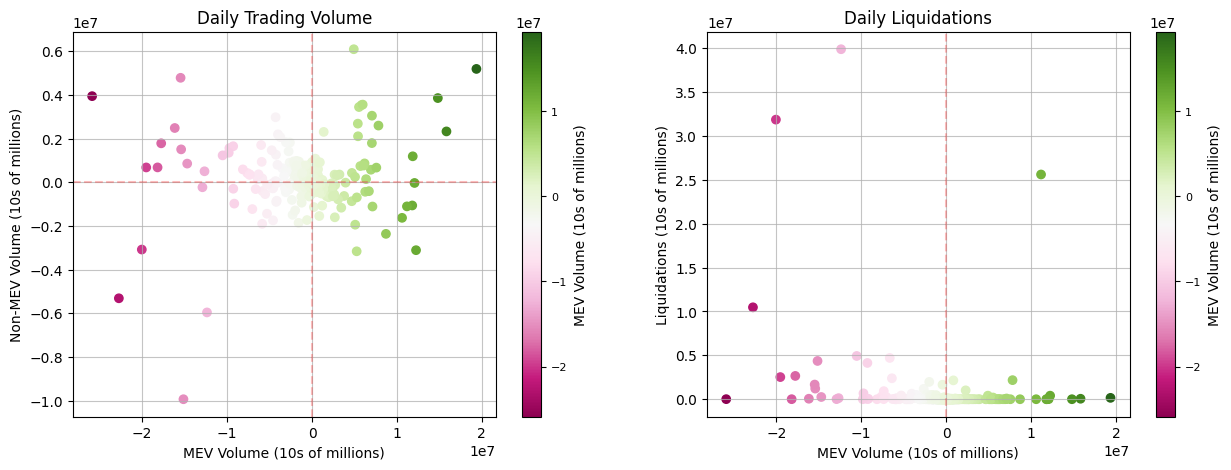

In [9]:
# plot mev volume and liquidations scatterplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.scatter(ohm_mev_df.mev_vol, ohm_mev_df.non_mev_vol, c=ohm_mev_df.mev_vol, cmap='PiYG')
ax1.grid(axis='x', alpha=0.75)
ax1.grid(axis='y', alpha=0.75)
ax1.axhline(y=0, color='red', linestyle='--', alpha=.25)
ax1.axvline(x=0, color='red', linestyle='--', alpha=.25)
ax1.set_title("Daily Trading Volume")
ax1.set_ylabel("Non-MEV Volume (10s of millions)")
ax1.set_xlabel("MEV Volume (10s of millions)")

# cbar on axis 1
cbar = fig.colorbar(ax1.collections[0], ax=ax1)
cbar.set_label('MEV Volume (10s of millions)')
cbar.ax.tick_params(labelsize=8)


ax2.scatter(ohm_mev_df.mev_vol, ohm_mev_df.liquidates_amountUSD, c=ohm_mev_df.mev_vol, cmap='PiYG')
ax2.grid(axis='x', alpha=0.75)
ax2.grid(axis='y', alpha=0.75)
ax2.axvline(x=0, color='red', linestyle='--', alpha=.25)
ax2.set_title("Daily Liquidations")
ax2.set_ylabel("Liquidations (10s of millions)")
ax2.set_xlabel("MEV Volume (10s of millions)")

# cbar on axis 2
cbar = fig.colorbar(ax2.collections[0], ax=ax2)
cbar.set_label('MEV Volume (10s of millions)')
cbar.ax.tick_params(labelsize=8)


plt.savefig('Daily Trading Volume and Liquidations.png')
plt.show()

### Mapper Algorithm with Giotto-tda

Code is modified from [this notebook](https://github.com/giotto-ai/giotto-tda/blob/master/examples/mapper_quickstart.ipynb)

In [10]:
# Data viz
from gtda.plotting import plot_point_cloud

# TDA magic
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
)

# ML tools
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [11]:
# Define filter function – can be any scikit-learn transformer
# filter_func = Projection(columns=[0, 1, 2])
filter_func = Projection(columns=[0, 1]) # projecting from R^3 to R^2
# Define cover
cover = CubicalCover(n_intervals=10, overlap_frac=0.2)

# Choose clustering algorithm – default is DBSCAN
clusterer = DBSCAN(eps=0.5) 
#DBSCAN takes an argument called epsilon (eps). eps specifies how close points should be to each other to be considered a part of a cluster. 
# If the distance between two points is lower or equal to this value (eps), these points are considered neighbors.
# clusterer = DBSCAN(eps=0.5) 

# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

In [12]:
# We can feed data into mapper as numpy arrays or pandas dataframes. We choose to use the pandas dataframe. We set the column parameters we want mapper to use.
# pipe.set_params(filter_func=Projection(columns=["mev_vol", "non_mev_vol", "liquidates_amountUSD"]));
pipe.set_params(filter_func=Projection(columns=["mev_vol", "non_mev_vol"]));

In [13]:
plotly_params = {"node_trace": {"marker_colorscale": "Greens"}}
fig = plot_static_mapper_graph(
    pipe, ohm_mev_df, color_data=ohm_mev_df, plotly_params=plotly_params, layout_dim=3, layout="fruchterman_reingold", node_scale = 40
)

fig.update_layout(template="plotly_dark")
fig.show(config={'scrollZoom': True}, template="plotly_dark")

#### Extract underlying graph data structure from mapper

In [14]:
# get the "pipe" graph structure as an igraph Graph
graph = pipe.fit_transform(ohm_mev_df)

In [15]:
graph.vs.attributes()
# 'pullback_set_label' and 'partial_cluster_label' refer to the interval and cluster sets described above. 
# 'node_elements' refers to the indices of our original data that belong to each node. 

['pullback_set_label', 'partial_cluster_label', 'node_elements']

In [16]:
# Convert df values to array to be compatible with the Graph object
ohm_mev_df_arr = ohm_mev_df.to_numpy()

In [17]:
def get_node_data(node_id: int, graph, df_arr):
    node_elements = graph.vs["node_elements"]
    # extract origina datapoints connected to node 0
    node_arr = df_arr[node_elements[node_id]]
    return node_arr

In [18]:
# get node data for all nodes
node_data = [get_node_data(i, graph, ohm_mev_df_arr) for i in range(len(graph.vs))]

In [19]:
# get node data for all nodes
node_data = []
for i in range(len(graph.vs)):
    node_arr = get_node_data(i, graph, ohm_mev_df_arr)
    print(f"Node {i} has {len(node_arr)} elements")
    node_data.append(node_arr)

Node 0 has 407 elements
Node 1 has 69 elements
Node 2 has 72 elements
Node 3 has 43 elements
Node 4 has 26 elements
Node 5 has 7 elements
Node 6 has 2 elements
Node 7 has 3 elements
Node 8 has 7 elements
Node 9 has 5 elements
Node 10 has 9 elements
Node 11 has 3 elements
Node 12 has 3 elements
Node 13 has 4 elements
Node 14 has 2 elements
Node 15 has 2 elements
Node 16 has 1 elements
Node 17 has 2 elements
Node 18 has 4 elements
Node 19 has 6 elements
Node 20 has 3 elements
Node 21 has 6 elements
Node 22 has 14 elements
Node 23 has 2 elements
Node 24 has 4 elements
Node 25 has 1 elements
Node 26 has 2 elements
Node 27 has 1 elements
Node 28 has 1 elements
Node 29 has 2 elements
Node 30 has 1 elements
Node 31 has 1 elements
Node 32 has 1 elements
Node 33 has 1 elements
Node 34 has 1 elements
Node 35 has 1 elements
Node 36 has 1 elements
Node 37 has 1 elements
Node 38 has 2 elements
Node 39 has 1 elements
Node 40 has 1 elements


In [20]:
# get the first 8 nodes with the biggest length
node_data_subset = sorted(node_data, key=lambda x: len(x), reverse=True)[:8]

In [21]:
# print the size of every node in node_data_subset to verify that they are the biggest
for i, node in enumerate(node_data_subset):
    print(f"Node {i} has {len(node)} elements")

Node 0 has 407 elements
Node 1 has 72 elements
Node 2 has 69 elements
Node 3 has 43 elements
Node 4 has 26 elements
Node 5 has 14 elements
Node 6 has 9 elements
Node 7 has 7 elements


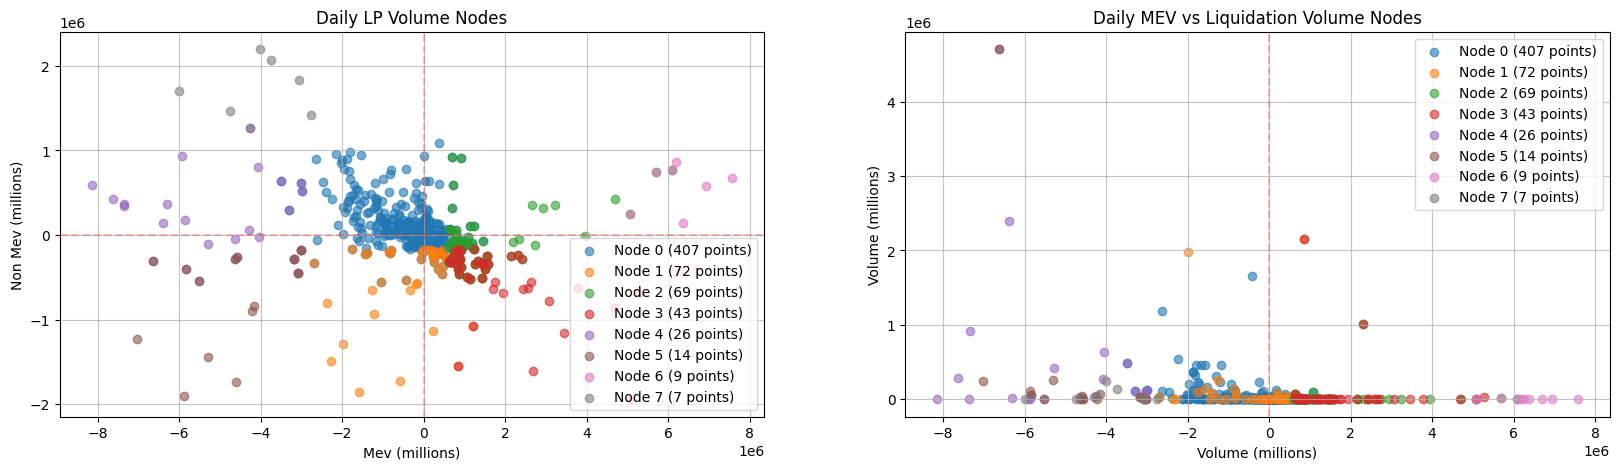

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

for i, node in enumerate(node_data_subset):
    ax1.scatter(node[:,0], node[:,1], label=f"Node {i} ({len(node)} points)", alpha=0.6)
ax1.grid(axis='x', alpha=0.75)
ax1.grid(axis='y', alpha=0.75)
ax1.axhline(y=0, color='red', linestyle='--', alpha=.25)
ax1.axvline(x=0, color='red', linestyle='--', alpha=.25)
ax1.set_xlabel("Mev (millions)")
ax1.set_ylabel("Non Mev (millions)")
ax1.set_title(f"Daily LP Volume Nodes")
ax1.legend()

for i, node in enumerate(node_data_subset):
    ax2.scatter(node[:,0], node[:,2], label=f"Node {i} ({len(node)} points)", alpha=0.6)

# add vertical grid lines
ax2.grid(axis='x', alpha=0.75)
ax2.grid(axis='y', alpha=0.75)
ax2.axvline(x=0, color='red', linestyle='--', alpha=.25)
ax2.set_xlabel("Volume (millions)")
ax2.set_ylabel("Volume (millions)")
ax2.set_title(f"Daily MEV vs Liquidation Volume Nodes")
ax2.legend()

plt.savefig('Daily Trading Volume and Liquidations Nodes.png')
plt.show()

In [23]:
# get overlapping values in all the arrays to plot in scatterplot
def intersect2D(a, b):
# https://gist.github.com/Robaina/b742f44f489a07cd26b49222f6063ef7
  """
  Find row intersection between 2D numpy arrays, a and b.
  Returns another numpy array with shared rows
  """
  return np.array([x for x in set(tuple(x) for x in a) & set(tuple(x) for x in b)])

In [24]:
node_data_arrays = []
for i in range(len(node_data_subset)):
    node_arr = node_data_subset[i]
    node_data_arrays.append(node_arr)

In [25]:
node_intersect_arrays = []
for i in range(len(node_data_arrays)):
    node_arr = intersect2D(node_data_arrays[0], node_data_arrays[i])
    node_intersect_arrays.append(node_arr)

In [26]:
# remove nodes with length 0 from node intersect arrays
node_intersect_arrays = [x for x in node_intersect_arrays if len(x) > 0]

In [27]:
for i in range(len(node_intersect_arrays)):
    print(f"Node {i} has {len(node_data_arrays[i])} total datapoints with {len(node_intersect_arrays[i])} intersecting points and a {len(node_intersect_arrays[i]) / len(node_data_arrays[i]) * 100}% overlap with node {0}")

Node 0 has 407 total datapoints with 407 intersecting points and a 100.0% overlap with node 0
Node 1 has 72 total datapoints with 59 intersecting points and a 81.94444444444444% overlap with node 0
Node 2 has 69 total datapoints with 55 intersecting points and a 79.71014492753623% overlap with node 0
Node 3 has 43 total datapoints with 25 intersecting points and a 58.139534883720934% overlap with node 0
Node 4 has 26 total datapoints with 7 intersecting points and a 26.923076923076923% overlap with node 0
Node 5 has 14 total datapoints with 3 intersecting points and a 21.428571428571427% overlap with node 0


In [28]:
# remove the first node from the node_data_arrays for plotting
node_intersect_arrays_2 = node_intersect_arrays[1:]

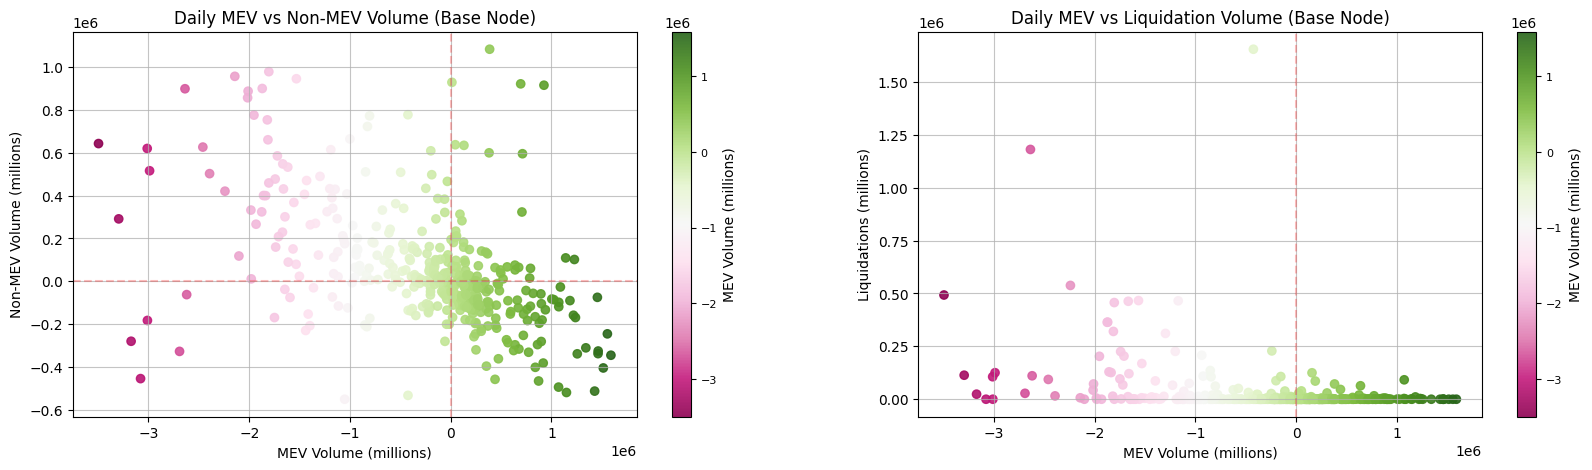

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax1.scatter(node_intersect_arrays[0][:,0], node_intersect_arrays[0][:,1], label=f"Node 0 (base)", alpha=0.9,  c=node_intersect_arrays[0][:,0], cmap='PiYG')
ax1.grid(axis='x', alpha=0.75)
ax1.grid(axis='y', alpha=0.75)
ax1.axhline(y=0, color='red', linestyle='--', alpha=.25)
ax1.axvline(x=0, color='red', linestyle='--', alpha=.25)
ax1.set_title(f"Daily MEV vs Non-MEV Volume (Base Node)")
ax1.set_xlabel("MEV Volume (millions)")
ax1.set_ylabel("Non-MEV Volume (millions)")

# cbar on axis 1
cbar = fig.colorbar(ax1.collections[0], ax=ax1)
cbar.set_label('MEV Volume (millions)')
cbar.ax.tick_params(labelsize=8)

ax2.scatter(node_intersect_arrays[0][:,0], node_intersect_arrays[0][:,2], label=f"Node 0 (base)", alpha=0.9,  c=node_intersect_arrays[0][:,0], cmap='PiYG')
ax2.grid(axis='x', alpha=0.75)
ax2.grid(axis='y', alpha=0.75)
ax2.axvline(x=0, color='red', linestyle='--', alpha=.25)
ax2.set_title(f"Daily MEV vs Liquidation Volume (Base Node)")
ax2.set_xlabel("MEV Volume (millions)")
ax2.set_ylabel("Liquidations (millions)")

# cbar on axis 2
cbar = fig.colorbar(ax2.collections[0], ax=ax2)
cbar.set_label('MEV Volume (millions)')
cbar.ax.tick_params(labelsize=8)


plt.savefig('Daily Trading Volume and Liquidations (Base Node).png')
plt.show()



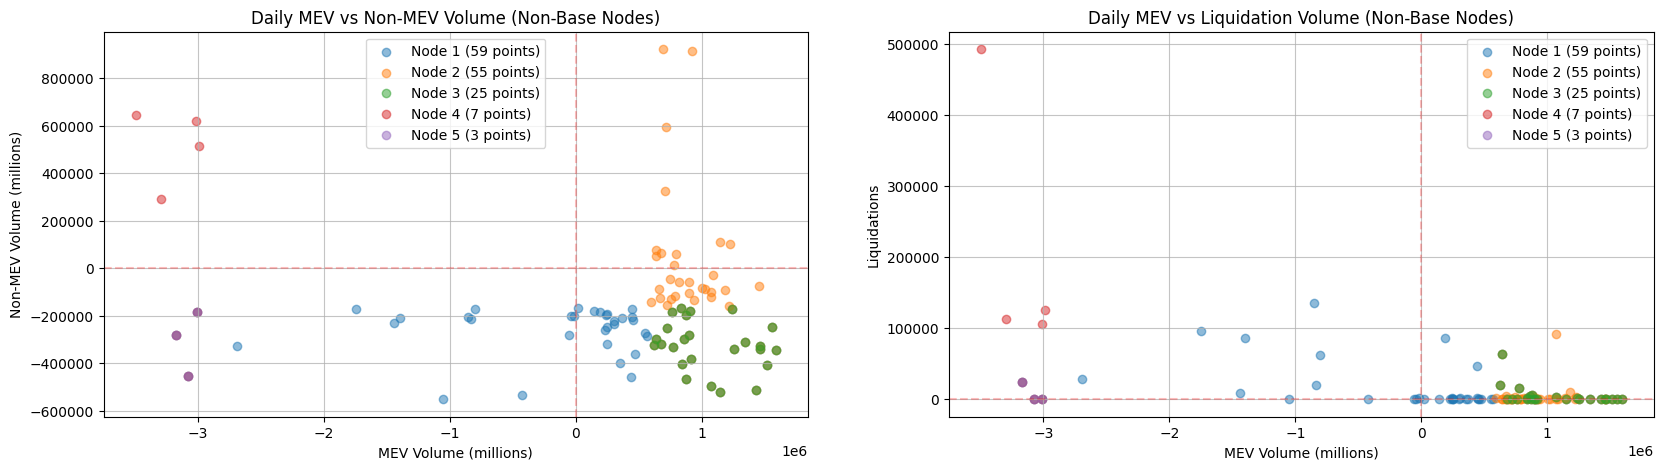

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

for i, node in enumerate(node_intersect_arrays_2):
    ax1.scatter(node[:,0], node[:,1], label=f"Node {i+1} ({len(node)} points)", alpha=0.5)
ax1.grid(axis='x', alpha=0.75)
ax1.grid(axis='y', alpha=0.75)
ax1.axhline(y=0, color='red', linestyle='--', alpha=.25)
ax1.axvline(x=0, color='red', linestyle='--', alpha=.25)
ax1.set_title(f"Daily MEV vs Non-MEV Volume (Non-Base Nodes)")
ax1.set_xlabel("MEV Volume (millions)")
ax1.set_ylabel("Non-MEV Volume (millions)")
ax1.legend(loc='best')


for i, node in enumerate(node_intersect_arrays_2):
    ax2.scatter(node[:,0], node[:,2], label=f"Node {i+1} ({len(node)} points)", alpha=0.5)
ax2.grid(axis='x', alpha=0.75)
ax2.grid(axis='y', alpha=0.75)
ax2.axhline(y=0, color='red', linestyle='--', alpha=.25)
ax2.axvline(x=0, color='red', linestyle='--', alpha=.25)
ax2.set_title(f"Daily MEV vs Liquidation Volume (Non-Base Nodes)")
ax2.set_xlabel("MEV Volume (millions)")
ax2.set_ylabel("Liquidations")
ax2.legend(loc='best')


plt.savefig('Daily Trading Volume and Liquidations (Non-Base Nodes).png')
plt.show()


#### Extract Node Datapoints

In [31]:
def extract_node_datapoints(node) -> pd.DataFrame:
    """
    extract node data points from graph
    """
    node_df = pd.DataFrame(node, columns = ['mev_node','non_mev_node', 'liquidations'])
    return node_df

In [32]:
# extract node datapoints from intersect node array
node_dataframes = [extract_node_datapoints(node) for node in node_intersect_arrays]

In [33]:
def df_node_filter(df, node_df):
    '''
    filter node dataframe with original dataframe using mev_vol column
    '''
    filtered_df = df[df['mev_vol'].isin(node_df['mev_node'])]
    return filtered_df

In [34]:
filtered_node_list = []
for i, node_df in enumerate(node_dataframes):
    filtered_node_df = df_node_filter(ohm_mev_df, node_df)
    filtered_node_list.append(filtered_node_df)

In [35]:
# print length of each node in filtered node list
for i, node in enumerate(filtered_node_list):
    print(f"Node {i} has {len(node)} elements")
    

Node 0 has 407 elements
Node 1 has 59 elements
Node 2 has 55 elements
Node 3 has 25 elements
Node 4 has 7 elements
Node 5 has 3 elements


In [36]:
def aggregate_node_sum(node_list: list[pd.DataFrame]) -> pd.DataFrame:
    # get the sum for each column in filtered_node_list
    node_list = []
    for i, node_df in enumerate(filtered_node_list):
        node_sum = node_df.sum()
        node_list.append(node_sum)

    # convert each element in node_sum_list to a dataframe
    node_sum_df_list = []
    for i, node_sum in enumerate(node_list):
        node_sum_df = pd.DataFrame(node_sum).T
        node_sum_df_list.append(node_sum_df)
    
    # convert each element of node_sum_df_list into a row of a single dataframe with an index
    aggregate_node_df = pd.concat(node_sum_df_list)

    return aggregate_node_df

def aggregate_node_mean(node_list: list[pd.DataFrame]) -> pd.DataFrame:
    # get the mean for each column in filtered_node_list
    node_list = []
    for i, node_df in enumerate(filtered_node_list):
        node_mean = node_df.mean()
        node_list.append(node_mean)

    # convert each element in node_mean_list to a dataframe
    node_mean_df_list = []
    for i, node_mean in enumerate(node_list):
        node_mean_df = pd.DataFrame(node_mean).T
        node_mean_df_list.append(node_mean_df)
    
    # convert each element of node_mean_df_list into a row of a single dataframe with an index
    aggregate_node_df = pd.concat(node_mean_df_list)

    return aggregate_node_df

def aggregate_node_std(node_list: list[pd.DataFrame]) -> pd.DataFrame:
    # get the std for each column in filtered_node_list
    node_list = []
    for i, node_df in enumerate(filtered_node_list):
        node_std = node_df.std()
        node_list.append(node_std)

    # convert each element in node_std_list to a dataframe
    node_std_df_list = []
    for i, node_std in enumerate(node_list):
        node_std_df = pd.DataFrame(node_std).T
        node_std_df_list.append(node_std_df)
    
    # convert each element of node_std_df_list into a row of a single dataframe with an index
    aggregate_node_df = pd.concat(node_std_df_list)

    return aggregate_node_df

In [37]:
agg_node_sum_df = aggregate_node_sum(filtered_node_list)
agg_node_mean_df = aggregate_node_mean(filtered_node_list)
agg_node_std_df = aggregate_node_std(filtered_node_list)
    

In [38]:
# rename index to "node nubmer with number of node elements"
agg_node_sum_df.index = [f"node {i} ({len(filtered_node_list[i])} points)" for i in range(len(filtered_node_list))]
agg_node_mean_df.index = [f"node {i} ({len(filtered_node_list[i])} points)" for i in range(len(filtered_node_list))]
agg_node_std_df.index = [f"node {i} ({len(filtered_node_list[i])} points)" for i in range(len(filtered_node_list))]

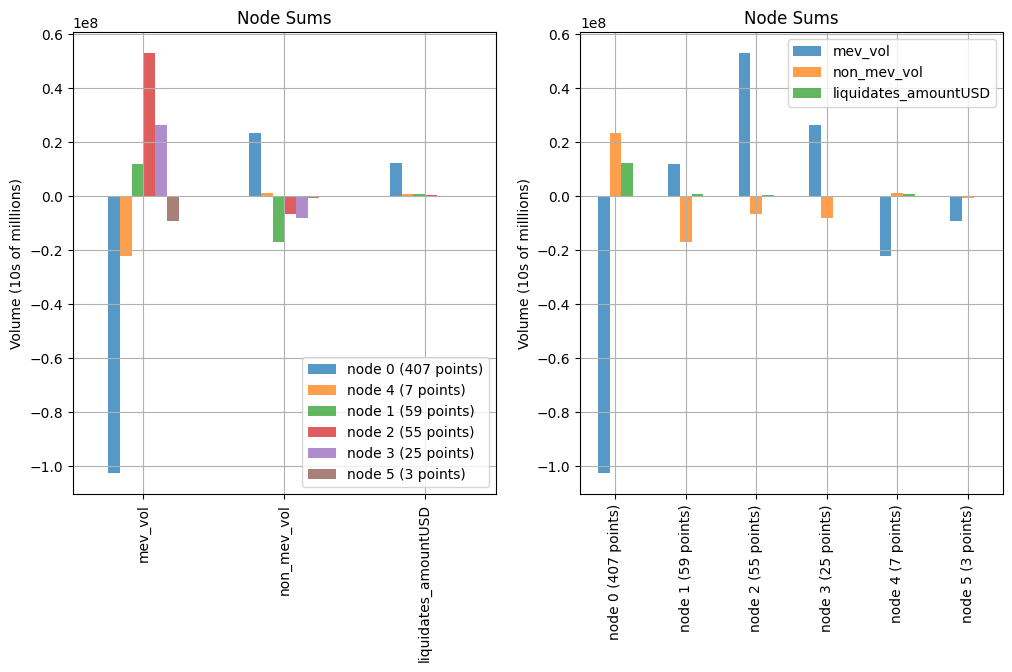

In [39]:
# plot two barplots side by side of agg node sums
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

agg_node_sum_df.sort_values(by='liquidates_amountUSD', ascending=False).T.plot(kind='bar', ax=ax1, figsize=(12,6), title="Node Sums", grid=True, alpha=0.75)
agg_node_sum_df.plot(kind='bar', ax=ax2, figsize=(12,6), title="Node Sums", grid=True, alpha=0.75)
ax1.set_ylabel("Volume (10s of milllions)")
ax2.set_ylabel("Volume (10s of milllions)")
plt.show()

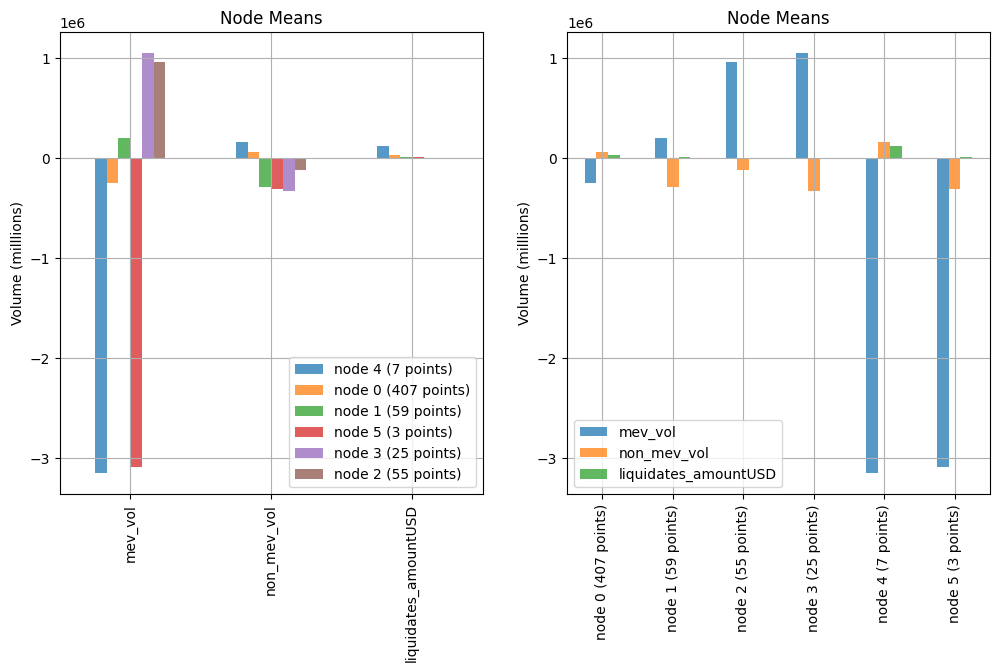

In [40]:
# plot two barplots side by side of agg node means
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

agg_node_mean_df.sort_values(by='liquidates_amountUSD', ascending=False).T.plot(kind='bar', ax=ax1, figsize=(12,6), title="Node Means", grid=True, alpha=0.75)
agg_node_mean_df.plot(kind='bar', ax=ax2, figsize=(12,6), title="Node Means", grid=True, alpha=0.75)
ax1.set_ylabel("Volume (milllions)")
ax2.set_ylabel("Volume (milllions)")
plt.show()

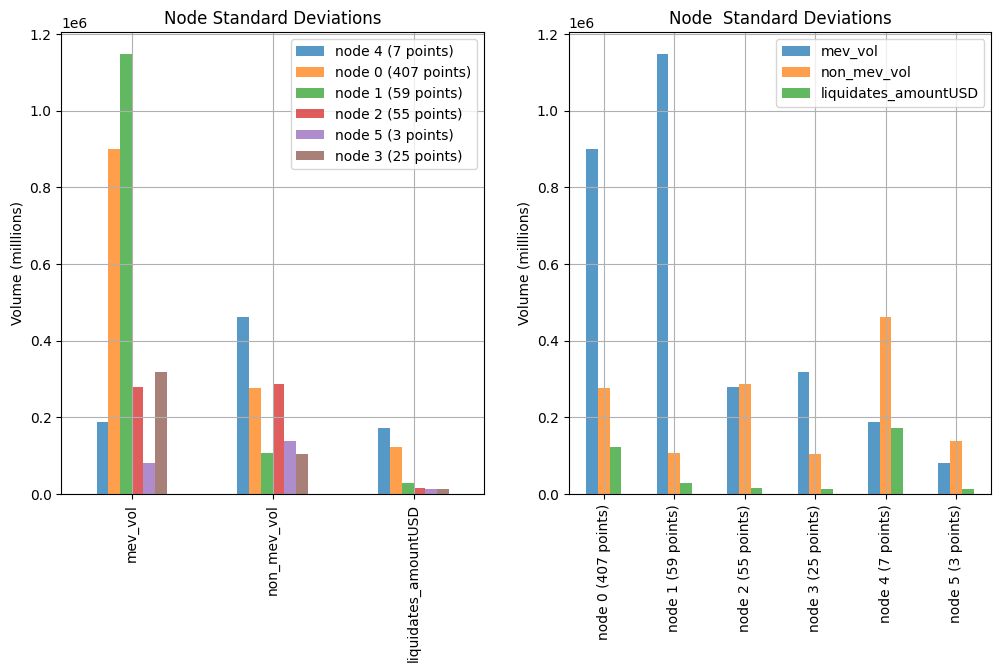

In [41]:
# plot two barplots side by side of agg node stds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

agg_node_std_df.sort_values(by='liquidates_amountUSD', ascending=False).T.plot(kind='bar', ax=ax1, figsize=(12,6), title="Node Standard Deviations", grid=True, alpha=0.75)
agg_node_std_df.plot(kind='bar', ax=ax2, figsize=(12,6), title="Node  Standard Deviations", grid=True, alpha=0.75)
ax1.set_ylabel("Volume (milllions)")
ax2.set_ylabel("Volume (milllions)")
plt.show()

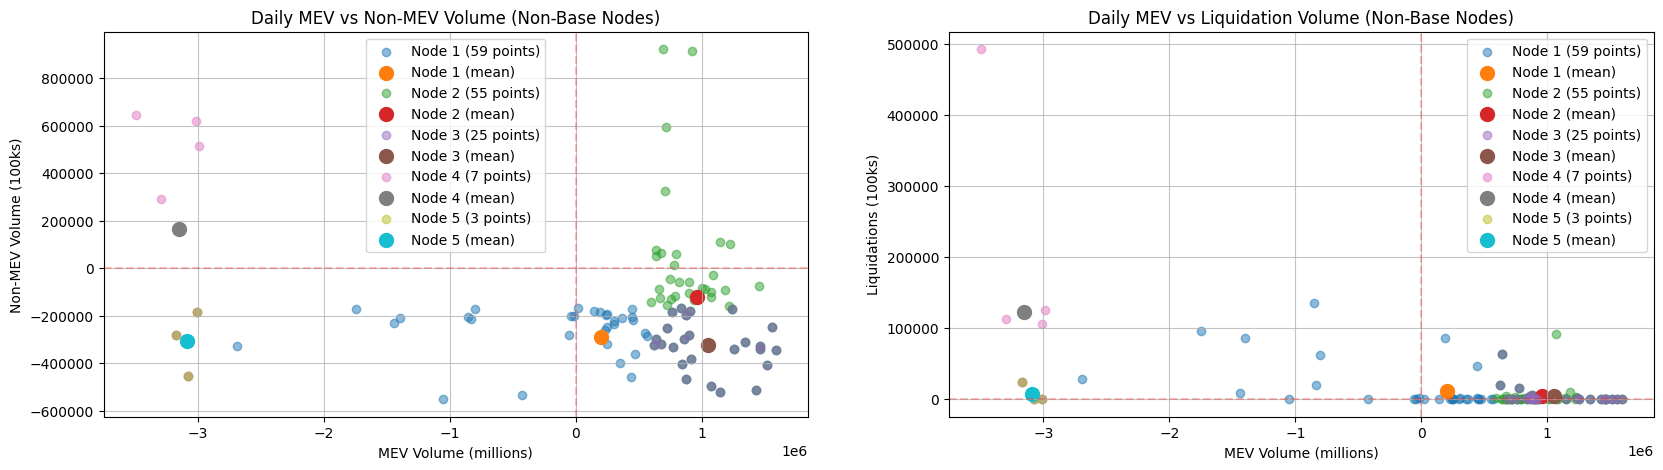

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

for i, node in enumerate(node_intersect_arrays_2):
    ax1.scatter(node[:,0], node[:,1], label=f"Node {i+1} ({len(node)} points)", alpha=0.5)
    ax1.scatter(agg_node_mean_df['mev_vol'].drop(agg_node_mean_df.index[0]).iloc[i], agg_node_mean_df['non_mev_vol'].drop(agg_node_mean_df.index[0]).iloc[i], s=100, label=f"Node {i+1} (mean)")

ax1.grid(axis='x', alpha=0.75)
ax1.grid(axis='y', alpha=0.75)
ax1.axhline(y=0, color='red', linestyle='--', alpha=.25)
ax1.axvline(x=0, color='red', linestyle='--', alpha=.25)
ax1.set_title(f"Daily MEV vs Non-MEV Volume (Non-Base Nodes)")
ax1.set_xlabel("MEV Volume (millions)")
ax1.set_ylabel("Non-MEV Volume (100ks)")
ax1.legend(loc='best')


for i, node in enumerate(node_intersect_arrays_2):
    ax2.scatter(node[:,0], node[:,2], label=f"Node {i+1} ({len(node)} points)", alpha=0.5)
    ax2.scatter(agg_node_mean_df['mev_vol'].drop(agg_node_mean_df.index[0]).iloc[i], agg_node_mean_df['liquidates_amountUSD'].drop(agg_node_mean_df.index[0]).iloc[i], s=100, label=f"Node {i+1} (mean)")
ax2.grid(axis='x', alpha=0.75)
ax2.grid(axis='y', alpha=0.75)
ax2.axhline(y=0, color='red', linestyle='--', alpha=.25)
ax2.axvline(x=0, color='red', linestyle='--', alpha=.25)
ax2.set_title(f"Daily MEV vs Liquidation Volume (Non-Base Nodes)")
ax2.set_xlabel("MEV Volume (millions)")
ax2.set_ylabel("Liquidations (100ks)")
ax2.legend(loc='best')


plt.savefig('Daily Trading Volume and Liquidations (Non-Base Nodes) with mean std.png')
plt.show()